In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
# --- 1. Load Data ---
# Assuming the CSV files are in the same directory as the script
df_demographics = pd.read_excel('CustomerDemographics.xlsx')
df_behavior = pd.read_excel('CustomerBehaviorData.xlsx')
df_credit_consumption = pd.read_excel('CreditConsumptionData.xlsx')

In [13]:
# --- 2. Merge Data ---
# Merge based on 'ID'
df_merged = pd.merge(df_demographics, df_behavior, on='ID', how='inner')
df_full = pd.merge(df_merged, df_credit_consumption, on='ID', how='inner')

print("Initial data merge complete. Shape:", df_full.shape)
print("Columns:", df_full.columns.tolist())

Initial data merge complete. Shape: (20000, 49)
Columns: ['ID', 'account_type', 'gender', 'age', 'Income', 'Emp_Tenure_Years', 'Tenure_with_Bank', 'region_code', 'NetBanking_Flag', 'Avg_days_between_transaction', 'cc_cons_apr', 'dc_cons_apr', 'cc_cons_may', 'dc_cons_may', 'cc_cons_jun', 'dc_cons_jun', 'cc_count_apr', 'cc_count_may', 'cc_count_jun', 'dc_count_apr', 'dc_count_may', 'dc_count_jun', 'card_lim', 'personal_loan_active', 'vehicle_loan_active', 'personal_loan_closed', 'vehicle_loan_closed', 'investment_1', 'investment_2', 'investment_3', 'investment_4', 'debit_amount_apr', 'credit_amount_apr', 'debit_count_apr', 'credit_count_apr', 'max_credit_amount_apr', 'debit_amount_may', 'credit_amount_may', 'credit_count_may', 'debit_count_may', 'max_credit_amount_may', 'debit_amount_jun', 'credit_amount_jun', 'credit_count_jun', 'debit_count_jun', 'max_credit_amount_jun', 'loan_enq', 'emi_active', 'cc_cons']


In [15]:
# --- 3. Separate Data for Training and Prediction ---
# Customers with non-missing 'cc_cons' for model training
df_train = df_full[df_full['cc_cons'].notna()].copy()
# Customers with missing 'cc_cons' for prediction
df_predict = df_full[df_full['cc_cons'].isna()].copy()

print(f"\nTraining data shape (non-missing cc_cons): {df_train.shape}")
print(f"Prediction data shape (missing cc_cons): {df_predict.shape}")

# Define features (X) and target (y) for the training data
X_train_model = df_train.drop('cc_cons', axis=1)
y_train_model = df_train['cc_cons']
X_predict_missing = df_predict.drop('cc_cons', axis=1)


Training data shape (non-missing cc_cons): (15000, 49)
Prediction data shape (missing cc_cons): (5000, 49)


In [21]:
# --- 4. Exploratory Data Analysis (EDA) - Basic checks ---
print("\n--- EDA: Training Data Info ---")
df_train.info()


--- EDA: Training Data Info ---
<class 'pandas.core.frame.DataFrame'>
Index: 15000 entries, 0 to 14999
Data columns (total 49 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ID                            15000 non-null  int64  
 1   account_type                  15000 non-null  object 
 2   gender                        15000 non-null  object 
 3   age                           15000 non-null  int64  
 4   Income                        15000 non-null  object 
 5   Emp_Tenure_Years              15000 non-null  float64
 6   Tenure_with_Bank              15000 non-null  int64  
 7   region_code                   15000 non-null  int64  
 8   NetBanking_Flag               15000 non-null  int64  
 9   Avg_days_between_transaction  15000 non-null  int64  
 10  cc_cons_apr                   15000 non-null  float64
 11  dc_cons_apr                   15000 non-null  float64
 12  cc_cons_may                   15

In [23]:
print("\n--- EDA: Missing Values in Training Data ---")
print(df_train.isnull().sum()[df_train.isnull().sum() > 0])


--- EDA: Missing Values in Training Data ---
dc_cons_may             1
cc_count_apr            1
personal_loan_closed    1
investment_3            2
debit_count_apr         1
loan_enq                2
emi_active              1
dtype: int64


In [25]:
print("\n--- EDA: Unique values for categorical features in Training Data ---")
for col in ['Account_type', 'Gender', 'Income', 'NetBanking_Flag', 'Loan_enq']:
    if col in df_train.columns:
        print(f"{col}: {df_train[col].unique()}")



--- EDA: Unique values for categorical features in Training Data ---
Income: ['MEDIUM' 'LOW' 'HIGH']
NetBanking_Flag: [355 485 764 863 523 385 539 249 658 928 503 683 656 805 595 505 760 330
 626 914 445 265 258 233 686 883 346 244 394 537 269 945 802 700 454 354
 370 623 743 488 511 245 464 725 818 372 737 710 516 867 450 958 123 374
 620 957 351 270 535 519 748 799 254 644 814 812 606 771 574 536 274 315
 836 908 628 708 934 866 858 796 371 653 395 640 583 299 325 268 801 486
 256 880 647 633 424 314 921 554 911 259 966 631 614 448 904 446 723 713
 969 324 855 643 525 558 887 594 809 538 956 746 296 638 684 508 922 507
 243 755 950 248 685 639 968 698 386 512 582 267 447 860 506 408 247 766
 963 693 886 305 428 588 575 937 566 353 927 615 965 882 864 974 859 366
 430 593 534 369 466 468 750 451 924 762 331 753 865 964 613 465 300 261
 363 758 923 955 598 316 823 736 629 307 398 619 889 907 518 426 655 517
 573 884 618 944 970 277 266 874 608 857 484 436]


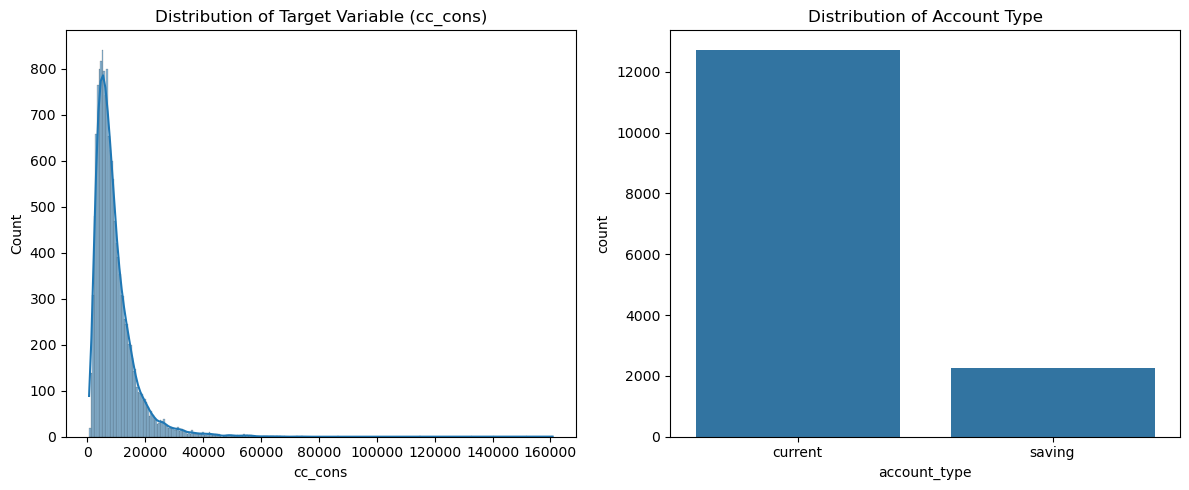

In [29]:
# Basic distributions (example for a numerical and a categorical feature)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(y_train_model, kde=True)
plt.title('Distribution of Target Variable (cc_cons)')

plt.subplot(1, 2, 2)
sns.countplot(x='account_type', data=df_train)
plt.title('Distribution of Account Type')
plt.tight_layout()
plt.show()

# Correlation matrix (for numerical features) - highly recommended for deeper EDA
# For simplicity, we'll skip detailed correlation plots here but in a real project, this is vital.
# correlation_matrix = X_train_model.select_dtypes(include=np.number).corr()
# plt.figure(figsize=(15, 10))
# sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f")
# plt.title('Correlation Matrix of Numerical Features')
# plt.show()


In [33]:
# --- 5. Preprocessing Pipelines ---

# Identify categorical and numerical features
categorical_features = X_train_model.select_dtypes(include=['object', 'category']).columns
numerical_features = X_train_model.select_dtypes(include=np.number).columns.drop('ID') # Exclude ID

# Preprocessing for numerical features: impute missing values with median, then scale
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Preprocessing for categorical features: impute missing values with most frequent, then one-hot encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Create a preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough' # Keep other columns (like ID, if not dropped already)
)



In [35]:
# --- 6. Define RMSPE Metric ---
def rmspe(y_true, y_pred):
    """
    Calculates the Root Mean Square Percentage Error (RMSPE).
    Handles cases where y_true is zero to avoid division by zero.
    """
    if not isinstance(y_true, np.ndarray):
        y_true = np.array(y_true)
    if not isinstance(y_pred, np.ndarray):
        y_pred = np.array(y_pred)

    # Avoid division by zero for y_true values that are 0 or very close to 0
    # Add a small epsilon to the denominator for numerical stability
    epsilon = 1e-10
    percentage_error = np.abs((y_true - y_pred) / (y_true + epsilon)) * 100
    return np.sqrt(np.mean(percentage_error**2))

# Make a scikit-learn compatible scorer
rmspe_scorer = make_scorer(rmspe, greater_is_better=False) # greater_is_better=False indicates it's an error metric



In [37]:
# --- 7. Build and Train the Model Pipeline ---
# Use Linear Regression as a baseline model
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Split the training data further for validation
# Using 80-20 split as a common practice
X_train, X_val, y_train, y_val = train_test_split(
    X_train_model, y_train_model, test_size=0.2, random_state=42
)

print(f"\nShape of X_train for model training: {X_train.shape}")
print(f"Shape of X_val for model validation: {X_val.shape}")

# Train the model
print("\nTraining the model...")
model_pipeline.fit(X_train, y_train)
print("Model training complete.")


Shape of X_train for model training: (12000, 48)
Shape of X_val for model validation: (3000, 48)

Training the model...
Model training complete.



--- Model Validation ---
Validation RMSPE: 26.8920%
Validation RMSE: 2609.2015


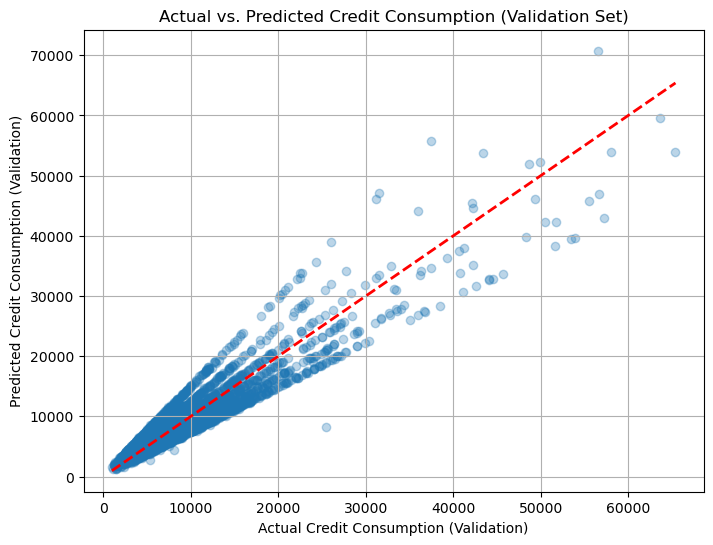

In [39]:
# --- 8. Model Validation ---
print("\n--- Model Validation ---")
y_val_pred = model_pipeline.predict(X_val)

# Ensure no negative predictions for cc_cons if it's strictly positive
y_val_pred[y_val_pred < 0] = 0 # or small positive value

val_rmspe = rmspe(y_val, y_val_pred)
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

print(f"Validation RMSPE: {val_rmspe:.4f}%")
print(f"Validation RMSE: {val_rmse:.4f}")

# Visualize predictions vs actual (for validation set)
plt.figure(figsize=(8, 6))
plt.scatter(y_val, y_val_pred, alpha=0.3)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
plt.xlabel('Actual Credit Consumption (Validation)')
plt.ylabel('Predicted Credit Consumption (Validation)')
plt.title('Actual vs. Predicted Credit Consumption (Validation Set)')
plt.grid(True)
plt.show()

In [41]:
# --- 9. Predict for Customers with Missing 'cc_cons' ---
print("\nPredicting for customers with missing 'cc_cons'...")
predicted_cc_cons = model_pipeline.predict(X_predict_missing)

# Ensure predictions are non-negative
predicted_cc_cons[predicted_cc_cons < 0] = 0

# Add predictions to the df_predict DataFrame
df_predict['predicted_cc_cons'] = predicted_cc_cons

print("\nPredictions for missing values generated. Sample:")
print(df_predict[['ID', 'predicted_cc_cons']].head())


Predicting for customers with missing 'cc_cons'...

Predictions for missing values generated. Sample:
          ID  predicted_cc_cons
15000  17591        3111.081945
15001  13541        6941.881154
15002  13431        2607.297023
15003   8687        9048.149073
15004  14727        2636.434463


In [43]:
# --- 10. Save Predictions ---
output_df = df_predict[['ID', 'predicted_cc_cons']]
output_filename = 'predicted_credit_consumption.csv'
output_df.to_csv(output_filename, index=False)
print(f"\nPredictions saved to {output_filename}")

print("\n--- Script Finished ---")


Predictions saved to predicted_credit_consumption.csv

--- Script Finished ---
